# Parameter Estimation Workflow for conversion reaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad

from bayesflow.networks import InvertibleNetwork, FlattenNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.error_metrics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction    
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 11
time_points = np.linspace(0, 10, n_obs)


def batch_simulator(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets via analytical solution of ODE
    """       
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.empty((n_sim, n_obs, 1), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations   
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²)
        
    return sim_data   


def resimulation(prior_samples):   
    """
    Simulate multiple conversion model datasets without noise
    """       
    n_sim = prior_samples.shape[0]   # batch size  
    n_obs = 11
    time_points = np.linspace(0, 10, n_obs)
    sim_data = np.empty((n_sim, n_obs, 1), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations   
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sim_data[m, :, 0] = state_2(time_points)
        
    return sim_data   

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [5]:
true_params = prior(500) 
x = batch_simulator(true_params, n_obs).astype(np.float32)

In [6]:
# Load trained network (without LSTM)
summary_net = FlattenNetwork()
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path = './CR11_4ACB_[64,64,64]_ckpts', skip_checks=True) 

# BayesFlow samples from the learned posterior
param_samples = amortizer.sample(x, n_samples=1000)
v = bootstrap_metrics(np.swapaxes(param_samples, 0, 1), true_params)
a = display_metrics(v)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_4ACB_[64,64,64]_ckpts\ckpt-300
NRMSE(k_1): 0.020 ± 0.002
NRMSE(k_2): 0.032 ± 0.002
R²(k_1): 0.987 ± 0.001
R²(k_2): 0.965 ± 0.003


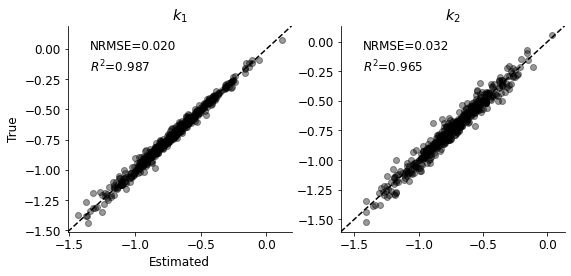

In [13]:
param_means = param_samples.mean(axis=1)
f = true_vs_estimated(true_params, param_means, ['$k_1$', '$k_2$'], filename='CR11')

In [8]:
units = np.array([4, 8, 16])

In [9]:
n = 0
summary_net = LSTM(units[n])
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path = './CR11_4ACB_[64,64,64]_LSTM({})_ckpts'.format(units[n]), 
                                     skip_checks=True)
    
# BayesFlow samples from the learned posterior
param_samples_1 = amortizer.sample(x, n_samples=1000)
v1 = bootstrap_metrics(np.swapaxes(param_samples_1, 0, 1), true_params)
a1 = display_metrics(v1)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_4ACB_[64,64,64]_LSTM(4)_ckpts\ckpt-300
NRMSE(k_1): 0.023 ± 0.002
NRMSE(k_2): 0.036 ± 0.003
R²(k_1): 0.984 ± 0.002
R²(k_2): 0.957 ± 0.004


In [10]:
n = 1
summary_net = LSTM(units[n])
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path = './CR11_4ACB_[64,64,64]_LSTM({})_ckpts'.format(units[n]), 
                                     skip_checks=True)
    
# BayesFlow samples from the learned posterior
param_samples_2 = amortizer.sample(x, n_samples=1000)
v2 = bootstrap_metrics(np.swapaxes(param_samples_2, 0, 1), true_params)
a2 = display_metrics(v2)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_4ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
NRMSE(k_1): 0.021 ± 0.001
NRMSE(k_2): 0.034 ± 0.002
R²(k_1): 0.986 ± 0.002
R²(k_2): 0.961 ± 0.004


In [11]:
n = 2
summary_net = LSTM(units[n])
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path = './CR11_4ACB_[64,64,64]_LSTM({})_ckpts'.format(units[n]), 
                                     skip_checks=True)
    
# BayesFlow samples from the learned posterior
param_samples_3 = amortizer.sample(x, n_samples=1000)
v3 = bootstrap_metrics(np.swapaxes(param_samples_3, 0, 1), true_params)
a3 = display_metrics(v3)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_4ACB_[64,64,64]_LSTM(16)_ckpts\ckpt-300
NRMSE(k_1): 0.021 ± 0.001
NRMSE(k_2): 0.034 ± 0.003
R²(k_1): 0.986 ± 0.001
R²(k_2): 0.961 ± 0.004


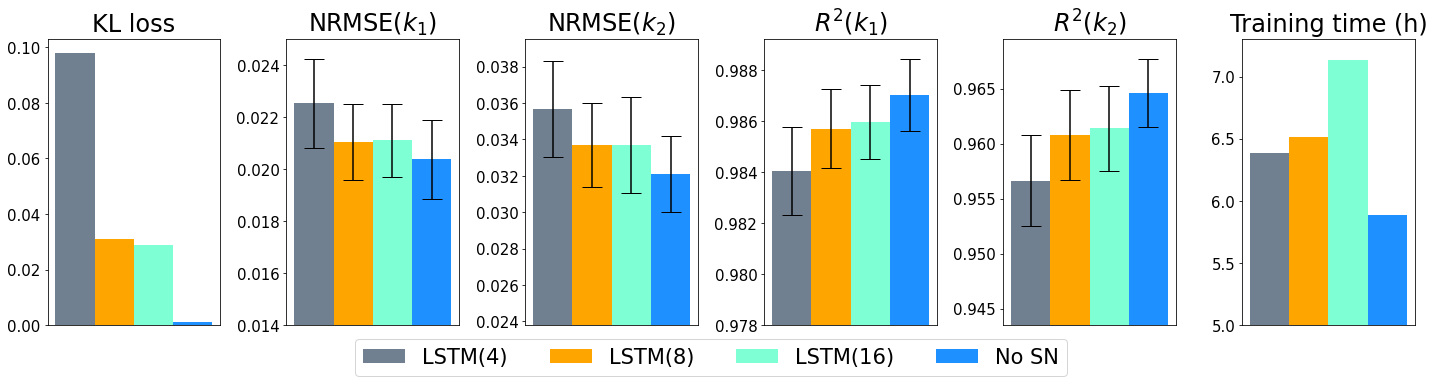

In [20]:
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
plt.rcParams['font.size'] = 15

eps=0.001
bar_chart(ax, np.array([0.098, 0.031, 0.029, 0.000+eps]), 0, 'KL loss')
bar_chart(ax, np.array([a1[0,0], a2[0,0], a3[0,0], a[0,0]]), 1, 'NRMSE$(k_1)$', 
          se=np.array([a1[1,0], a2[1,0], a3[1,0], a[1,0]]), y_lim=np.array([0.014,0.025]))
bar_chart(ax, np.array([a1[0,1], a2[0,1], a3[0,1], a[0,1]]), 2, 'NRMSE$(k_2)$', 
          se=np.array([a1[1,1], a2[1,1], a3[1,1], a[1,1]]), y_lim=np.array([0.0238,0.0395]))
bar_chart(ax, np.array([a1[0,2], a2[0,2], a3[0,2], a[0,2]]), 3, '$R^2(k_1)$', 
          se=np.array([a1[1,2], a2[1,2], a3[1,2], a[1,2]]), y_lim=np.array([0.978,0.9892]))
bar_chart(ax, np.array([a1[0,3], a2[0,3], a3[0,3], a[0,3]]), 4, '$R^2(k_2)$', 
          se=np.array([a1[1,3], a2[1,3], a3[1,3], a[1,3]]), y_lim=np.array([0.9435,0.9695]))
bar_chart(ax, np.array([6+23/60, 6+31/60, 7+8/60, 5+53/60]), 5, 'Training time (h)', y_lim=np.array([5,7.3]))

for axes in ax: 
    handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.10), ncol=4, fontsize=21)
plt.tight_layout()
plt.show()
fig.savefig("figures/{}_bar_chart.png".format('CR11'), dpi=600, bbox_inches='tight')